## Projeto - Classificação de imagens

Na disciplina são vistas diferentes técnicas de preprocessamento, bem como algoritmos de extração de features e como podemos utilizar técnicas de aprendizagem de máquina para classificar imagens.

Este projeto tem como objetivo consolidar os conhecimentos vistos na disciplina aplicando-os em um determinado problema.

## Objetivos

1. Desenvolver um classificador de gatos e cachorros utilizando o dataset [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

2. (bônus) - Desenvolver um classificador de raças de animais 

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from fnmatch import fnmatch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler

Estrutura da pasta contendo os arquivos do projeto após a extração do dataset [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

<img src=dir.png align=left>

In [3]:
def show_samples(root='./images', pattern = '*.jpg'):
    """
    Acessa o diretório e busca por arquivos com a extensão especificada,
    em seguida exibe 5 amostras aleatórias das imagens encontradas
    :param root: Diretório onde se encontram as imagens (str)
    :param pattern: Extensão dos arquivos (str)
    :return: Plot com 5 imagens aleatórias
    """
    images = []
    f, ax = plt.subplots(1, 5, figsize=(10, 5))
    for i in range(5):
        for path, subdirs, files in os.walk(root):
            for name in files:
                if fnmatch(name, pattern):
                    images.append(os.path.join(path, name))
        sample = cv2.imread(random.choice(images))
        ax[i].title.set_text(sample.shape)
        ax[i].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
    plt.tight_layout()

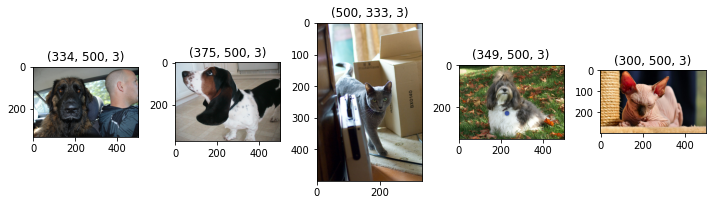

In [7]:
# Analisando algumas imagens aleatórias

show_samples()

Com base na análise de algumas amostras aleatórias é possível notar que os fundos das imagens não seguem um padrão, bem como a posição de cada animal (alguns estão próximos, outros são vistos lateralmente, etc).

Nota-se também que as imagens possuem tamanhos variados, o que poderá resultar em problemas futuros dependendo do modelo selecionado para a classificação.

In [8]:
def preprocess(root='./images', pattern='*.jpg'):
    """
    Essa função irá realizar o preprocessamento das imagens, acessando
    o diretório (root) e buscando por arquivos com a extensão especificada (pattern)
    para a contrução do dataset
    :param root: Diretório onde se encontram as imagens (str)
    :param pattern: Extensão dos arquivos (str)
    :return: Dicionário contendo o nome e os arrays das imagens processadas com sucesso (dict)
    :return: Lista com o diretório e nome das imagens problemáticas (list)

    """
    img_height = 180
    img_width = 180
    images = {}
    crapy_images = []

    # Percorrendo todo diretório em busca de arquivos com a extensão especificada
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern):
                try:
                    # Lendo o arquivo
                    original = cv2.imread(os.path.join(path, name))
                    # Redimensionando
                    resized_image = cv2.resize(original, (img_height, img_width),interpolation = cv2.INTER_AREA)
                    # Convertendo de BGR para GRAY
                    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
                    # Equalizando localmente
                    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(15,15))
                    cl1 = clahe.apply(gray)
                    # Detectando bordas
                    canny = cv2.Canny(image=gray, threshold1=120, threshold2=190)
                    # Normalizando
                    resized_image = resized_image/255
                    cl1 = cl1/255
                    canny = canny/255
                    # Reduzindo o tamanho da imagem colorida
                    resized_image = resized_image.mean(axis=2)
                    # Salvando no dicionário
                    images[name] = [resized_image,cl1,canny]
                except Exception as e:
                    # Se a imagem apresentar erro, salvar na lista para exclusão
                    crapy_images.append(os.path.join(path, name))
    return images, crapy_images

In [9]:
images, crapy_images = preprocess()

In [10]:
# Verificando a quantidade de imagens processadas corretamente

len(images)

7384

In [11]:
# Verificando a quantidade de imagens que apresentaram problemas no processamento (não serão utilizadas)

len(crapy_images)

6

Analisando o conteúdo da pasta "annotations" encontrei o arquivo "list.txt" que continha, entre outras informações, a classe para cada imagem (gato ou cachorro).

Manipulando o arquivo obtive um dicionário com o nome de cada arquivo e sua respectiva classe.

In [14]:
# Realizando a leitura do arquivo list.txt e salvando as classes em um dicionário

classes = {}

with open('./annotations/list.txt') as f:
    for i in range(6):
        f.readline()
    file = f.readlines()
    
for line in file:
    line = line.split(' ')
    classes[line[-4]+'.jpg'] = int(line[-2])

In [15]:
# Verificando a quantidade de registros obtida

len(classes)

7349

Notei que nem todas as imagens estão classificadas no arquivo 'list.txt' pois existem 7384 imagens(+ 6 imagens problemáticas) e apenas 7349 linhas classificando as imagens no arquivo TXT.

In [16]:
# Identificando as imagens sem classe definida no arquivo 'list.txt'

classless = []
for file_name in images:
    if file_name not in classes:
        classless.append(file_name)

In [18]:
# Removendo as imagens sem classe definida do dataset

for i in classless:
    images.pop(i)

In [19]:
# Verificando se ambos os dicionários estão com a mesma quantidade de valores

len(images) == len(classes)

True

In [21]:
# Verificando se ambos os dicionários possuem as mesmas chaves e na mesma ordem

images.keys() == classes.keys()

True

Na sequência pude observar que o dataset está bastante desbalanceado, contendo mais cachorros que gatos.

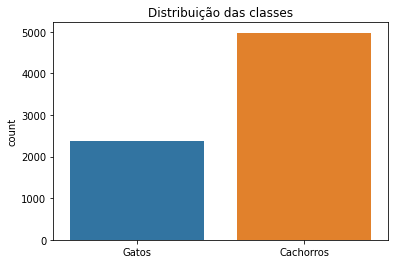

In [54]:
classes_qty = list()

for i in list(classes.values()):
    if i == 1:
        classes_qty.append('Gatos')
    else:
        classes_qty.append('Cachorros')
              
plt.title('Distribuição das classes')
sns.countplot(x=classes_qty)
plt.show();

In [40]:
# Transformando os dicionários de imagens e classes em arrays para utilizar no modelo

img_list = list()
class_list = list()

for key in images:
    img_list.append(images[key][0])
    img_list.append(images[key][1])
    img_list.append(images[key][2])
    class_list.append(classes[key])
    class_list.append(classes[key])
    class_list.append(classes[key])
    
x = np.array(img_list)
y = np.array(class_list)

In [55]:
# Separando em treino e teste

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

In [56]:
X_train.shape, X_test.shape

((15432, 180, 180), (6615, 180, 180))

In [57]:
# Realizando o reshape

X_train_rf = X_train.reshape(15432, -1)
X_test_rf = X_test.reshape(6615, -1)

In [59]:
X_train_rf.shape, X_test_rf.shape

((15432, 32400), (6615, 32400))

Podemos observar na imagem abaixo o resultado do modelo baseline, onde o único preprocessamento realizado foi o redimensionamento das imagens do dataset.

<img src=baseline.png align=left>

In [62]:
# Instanciando o modelo
model = RandomForestClassifier(n_jobs=-1, random_state=10)

# Fit com os dados de treino
model.fit(X_train_rf, y_train)

RandomForestClassifier(n_jobs=-1, random_state=10)

In [63]:
# Predict com os dados de teste
y_pred_rf = model.predict(X_test_rf)

In [64]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.83      0.22      0.35      2111
           2       0.73      0.98      0.83      4504

    accuracy                           0.74      6615
   macro avg       0.78      0.60      0.59      6615
weighted avg       0.76      0.74      0.68      6615



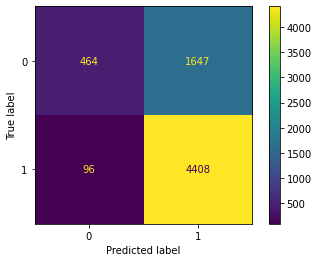

In [65]:
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Nota-se uma acurácia interessante para o modelo, porém o F1-Score da classe minoritária está bastante baixo possivelmente devido ao desbalanceamento do dataset.

Resolvi aplicar o RandomUnderSampler e comparar os resultados obtidos.

OBS: Infelizmente não foi possível utilizar o Smote nesse exercício devido à limitação de memória física no equipamento.

In [71]:
# Separando novamente em treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

# Realizando o reshape
X_train_rf = X_train.reshape(15432, -1)
X_test_rf = X_test.reshape(6615, -1)

# Aplicando o RandomUnderSampler
under = RandomUnderSampler(random_state=10)
X_train_rf, y_train = under.fit_resample(X_train_rf, y_train)

In [72]:
# Instanciando o segundo modelo
model = RandomForestClassifier(n_jobs=-1, random_state=10)

# Fit com os dados de treino
model.fit(X_train_rf, y_train)

RandomForestClassifier(n_jobs=-1, random_state=10)

In [73]:
# Predict com os dados de teste
y_pred_rf = model.predict(X_test_rf)

In [74]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.49      0.73      0.58      2111
           2       0.83      0.64      0.72      4504

    accuracy                           0.67      6615
   macro avg       0.66      0.68      0.65      6615
weighted avg       0.72      0.67      0.68      6615



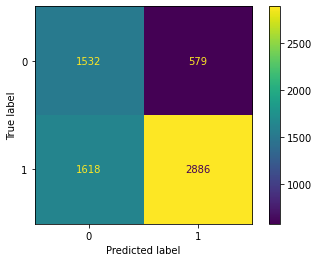

In [75]:
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Notamos uma diminuição na acurácia do modelo, porém um aumento significativo no F1-Score da classe minoritária

Deixo registrada abaixo a tentativa de utilizar RandomizedSearchCV + StratifiedKFold para otimizar os hiperparâmetros do modelo, porém novamente fiquei limitado à quantidade de memória física do equipamento.

In [15]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Dicionário de parâmetros
params = {
    'n_estimators': np.random.randint(10,200,5),
    'max_depth': range(1,50)
}

# Configurando um objeto de validação cruzada
cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

# Configurando o otimizador
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    n_iter=3,
    cv=cvs,
    scoring='f1',
    refit=True,
    random_state=10,
    param_distributions=params,
    n_jobs=-1
)

# Ajustando o modelo
search.fit(X_train_rf, y_train)

MemoryError: Unable to allocate 2.48 GiB for an array with shape (10288, 32400) and data type float64

## Conclusão

Após realizar o processamento das imagens utilizando técnicas de Data Augmentation obtivemos resultados muito melhores que em nosso modelo baseline (onde não realizamos nenhum processamento), demonstrando a importância dessas técnicas.
Deve-se tomar cuidado pois o tamanho do dataset aumenta bastante, o que impossibilitou novas tentativas nesse projeto.

## Próximos passos

1. Realizar tratamentos diferentes nas imagens e reavaliar os modelos
2. Testar combinações de hyperparâmetros
3. Testar novos modelos e métricas